# Figure 2

This notebook contains the functions used to construct Figure 2. 

The figure contains 5 panels:

- a) Exon-centered observed and expected profile of mutations in 6 colorectal POLE-mutant tumors and the distribution of the fraction of exonic bases across the window.
- b) Representation of the method used to compute observed and expected number of mutationsin exons and introns at gene level.
- c) Distribution of gene-level differences of observed and expected exonic mutations numbers in colorectal POLE-mutant tumors.
- d) Observed and expected number of mutations in introns, exons, and within exons grouped in synonymous and non-synonymous.
- e) Decrease of exonic mutation burden across groups of genes (grouped by mutaton rate, expression level, replication time, bases covered by H3K36me3) and decrease across exons at different postions.

---

The data required for each panel is saved in a file and loaded before plotting. The reason is that, once the data has been generated, the plot can be created and modified without recomputing the data.

In [1]:
import math
from os import path

import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy.polynomial.polynomial as poly
from bgreference import hg19
from scipy.stats import chi2

from python_scripts.analysis_functions import remove_version_ensembl, perform_analysis_per_group
from python_scripts.exon_centered_mutational_analysis import obs_exp_muts
from python_scripts.plot_functions import config_plot_params

In [2]:
%matplotlib inline

In [3]:
config_plot_params

<function python_scripts.plot_functions.config_plot_params>

## Input

### Included files

Files in the **data** directory. There is more information about them in the ``README`` file in that folder.

- *clusters_file*: clusters of samples per tumor type
- *intron_coords*: file with the coordinates of the introns  
- *middle_exons_coords*: file with the coordinates of the middle exons
- *exons_coords*: file with the coordinates of all exons (not only middle) of genes with at least 5 exons

- coordinates_folder: folder with the coordinates of exons and introns. These files are included and can be recomputed using the **sequences_filtering** notebook

### Not included files

These files are not included. There is more information about them in the ``README`` file located in the **non_provided_data** folder.

- *expression_file*: file with the expression data

- mutations_folder: base directory where the files with the mutations are located

- histone_data_folder: path to folder where the histon marks data files are. This notebook makes use of the reads information (files with the ``.tagAlign.gz`` extension e.g. ``E075-H3K36me3.tagAlign.gz``)

### Other

- tumor_type: id of the tumor
- cluster_id: id of the cluster
- n_groups: Amount of groups to make to group genes by mutation rate, level of expression, replication time or genic bases covered (for panel e)

---

In addition, this notebook requires the output of **signature_probability** and **gene_and_sample_analysis** notebooks.

In [5]:
# Included
clusters_file = 'data/clusters.tsv'
intron_coords = 'data/coordinates/genes_intron_coords.bed.gz'
middle_exons_coords = 'data/coordinates/genes_middle_exon_coords.bed.gz'
exons_coords = 'data/coordinates/genes_exon_coords_filtered.bed.gz'
coordinates_folder = 'data/coordinates/'

# Not included
expression_file = 'non_provided_data/expression.tsv'
mutations_folder = 'non_provided_data/mutations/'
histone_data_folder = 'non_provided_data/histonmarks/'

# Other
# Colorectal carcinoma POLE-mutant tumors
tumor_type = 'crc'
cluster_id = 'clusterA'
n_groups = 10

## Exons centered analysis

Following the method described in the **Exon-centered and intron-centered mutational analyses** section, for each exonic position around the center, we computed the observed and expected number of mutations.

In [6]:
middle_distance_threshold = 1000

mutations_file = mutations_folder + tumor_type + '.bed.gz'

exons_centered_results = obs_exp_muts(mutations_file, clusters_file, middle_exons_coords, path.join('results', 'signatures.txt'), tumor_type, cluster_id, middle_distance_threshold)

exons_centered_results.to_csv(path.join('results', "%s_%s_exons_centered.tsv" % (tumor_type, cluster_id)), 
                              sep="\t", header=True, index=False)

### Panel a) plot 1

Exon-centered observed and expected profiles of colorectal POLE-mutant tumors.

/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:9: RankWarning: The fit may be poorly conditioned
/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:16: RankWarning: The fit may be poorly conditioned


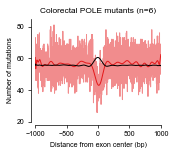

In [7]:
my_complete_results = pd.read_csv(path.join('results', "%s_%s_exons_centered.tsv" % (tumor_type, cluster_id)), 
                                  sep="\t")

config_plot_params()
fig = plt.figure(figsize=(2.25, 1.9))
ax = plt.subplot2grid((1, 1), (0, 0))

# Observed
coefs = poly.polyfit(my_complete_results['position'], my_complete_results['muts_count'], 50)
ffit = poly.polyval(my_complete_results['position'], coefs)

ax.plot(my_complete_results['position'], my_complete_results['muts_count'], '#e41a1c', alpha=0.5, linewidth=1)
ax.plot(my_complete_results['position'], ffit, '#e41a1c', linewidth=1)

# Expected
coefs2 = poly.polyfit(my_complete_results['position'], my_complete_results['expected_muts'], 50)
ffit2 = poly.polyval(my_complete_results['position'], coefs2)
ax.plot(my_complete_results['position'], ffit2, 'black', linewidth=1)

ax.set_facecolor('none')

# show the left spline
for axis in ['right', 'top']:
    ax.spines[axis].set_visible(False)

# add gap between x- and y-axis
for axis in ['bottom', 'left']:
    ax.spines[axis].set_position(('axes', -0.03))
    
ax.yaxis.major.locator.set_params(nbins=4)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel('Distance from exon center (bp)')
ax.set_ylabel('Number of mutations')

ax.set_xlim(-1000, 1000)
ax.set_ylim(20, 85)

ax.set_title("Colorectal POLE mutants (n=6)")

plt.savefig(path.join('figures', "figure2A_1.svg"), bbox_inches='tight')
plt.show()

## Exon intron proportion

Compute the ratio of exons to introns in the positions under analysis. It is expected that in the center all base pairs belong to introns.

In [8]:
middle_distance_threshold = 1000

# Load coordinats files
exons_coords_df = pd.read_csv(middle_exons_coords, sep="\t", header=None, low_memory=False)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl', 'symbol', 'strand']
exons_coords_df = exons_coords_df[['chr', 'start', 'end', 'ensembl']]
exons_coords_df['ensembl'] = exons_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl']
exons_coords_symbol_df = exons_coords_df[['chr', 'start', 'end', 'ensembl']]

introns_coords_df = pd.read_csv(intron_coords, sep="\t", header=None, low_memory=False)
introns_coords_df.columns = ['chr', 'start', 'end', 'ensembl', 'symbol', 'strand']
introns_coords_df = introns_coords_df[['chr', 'start', 'end', 'ensembl']]
introns_coords_df['ensembl'] = introns_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
introns_coords_df.columns = ['chr', 'start', 'end', 'ensembl']
introns_coords_symbol_df = introns_coords_df[['chr', 'start', 'end', 'ensembl']]

# Get the positions of interest (center of the exons and a number of bp around)
exons_coords_symbol_df['exon_size'] = (exons_coords_symbol_df['end'] - exons_coords_symbol_df['start'])
exons_coords_symbol_df['exon_middle_start'] = (exons_coords_symbol_df['start'] + exons_coords_symbol_df['exon_size'] / 2)
exons_coords_symbol_df['exon_middle_start'] = exons_coords_symbol_df.apply(lambda x:
                                                                           math.floor(x['exon_middle_start']),
                                                                           axis=1)
exons_coords_symbol_df['exon_middle_end'] = exons_coords_symbol_df['exon_middle_start'] + 1
exons_coords_symbol_df['region_start'] = exons_coords_symbol_df['exon_middle_start'] - middle_distance_threshold
exons_coords_symbol_df['region_end'] = exons_coords_symbol_df['exon_middle_end'] + middle_distance_threshold

sub_exons_coords = exons_coords_symbol_df[['chr', 'region_start', 'region_end', 'ensembl',
                                           'exon_size', 'exon_middle_start',
                                           'exon_middle_end']]

region_coords_bed = pybedtools.BedTool.from_dataframe(sub_exons_coords)
exons_coords_bed = pybedtools.BedTool.from_dataframe(exons_coords_symbol_df[['chr', 'start', 'end']])
introns_coords_bed = pybedtools.BedTool.from_dataframe(introns_coords_symbol_df[['chr', 'start', 'end']])

# Intersect the coordinates with the exons and introns
region_exons_bed = region_coords_bed.intersect(exons_coords_bed, wao=True)
region_introns_bed = region_coords_bed.intersect(introns_coords_bed, wao=True)

exons_in_range = pd.read_table(region_exons_bed.fn, names=['range_chr', 'range_start', 'range_end',
                                                           'ensembl', 'region_size', 'region_middle_start',
                                                           'region_middle_end',
                                                           'region_chr', 'region_start', 'region_end', 'overlap_bp'])

introns_in_range = pd.read_table(region_introns_bed.fn, names=['range_chr', 'range_start', 'range_end',
                                                               'ensembl', 'region_size', 'region_middle_start',
                                                               'region_middle_end',
                                                               'region_chr', 'region_start', 'region_end',
                                                               'overlap_bp'])

exons_in_range['real_overlap_start'] = exons_in_range[["range_start", "region_start"]].max(axis=1)
exons_in_range['real_overlap_end'] = exons_in_range[["range_end", "region_end"]].min(axis=1)

introns_in_range['real_overlap_start'] = introns_in_range[["range_start", "region_start"]].max(axis=1)
introns_in_range['real_overlap_end'] = introns_in_range[["range_end", "region_end"]].min(axis=1)

exons_in_range['relative_start'] = exons_in_range['real_overlap_start'] - exons_in_range['region_middle_start']
exons_in_range['relative_end'] = exons_in_range['real_overlap_end'] - exons_in_range['region_middle_start'] + 1

introns_in_range['relative_start'] = introns_in_range['real_overlap_start'] - introns_in_range['region_middle_start']
introns_in_range['relative_end'] = introns_in_range['real_overlap_end'] - introns_in_range['region_middle_start'] + 1

exons_per_base_dict = dict()
introns_per_base_dict = dict()

for index, my_exon in exons_in_range.iterrows():
    my_start = my_exon.relative_start
    my_end = my_exon.relative_end

    for i in range(my_start, my_end):
        if i not in exons_per_base_dict.keys():
            exons_per_base_dict[i] = 1
        else:
            exons_per_base_dict[i] += 1

for index, my_intron in introns_in_range.iterrows():
    my_start = my_intron.relative_start
    my_end = my_intron.relative_end

    for i in range(my_start, my_end):
        if i not in introns_per_base_dict.keys():
            introns_per_base_dict[i] = 1
        else:
            introns_per_base_dict[i] += 1

my_rates_to_plot = list()

for my_key in exons_per_base_dict.keys():
    n_exon_muts = int(exons_per_base_dict[my_key])
    n_intron_muts = int(introns_per_base_dict[my_key])

    exon_intron_proportion = n_exon_muts / (n_intron_muts + n_exon_muts) * 100
    my_rates_to_plot.append([my_key, exon_intron_proportion])

my_rates_to_plot_df = pd.DataFrame(my_rates_to_plot)
my_rates_to_plot_df.columns = ['position', 'exon_intron_percentage']

my_rates_to_plot_df = my_rates_to_plot_df.sort_values(by='position', ascending=True)

my_rates_to_plot_df.to_csv(path.join('results', 'exon_intron_proportion.tsv'), sep='\t', index=False)

### Panel a) plot 2

Distribution of the proportion of exonic bases at each postion across the window.

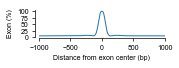

In [9]:
my_rates_to_plot_df = pd.read_csv(path.join('results', 'exon_intron_proportion.tsv'), sep='\t')

fig = plt.figure(figsize=(2.25, 0.5))
ax = plt.subplot2grid((1, 1), (0, 0))

ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

ax.plot(my_rates_to_plot_df['position'], my_rates_to_plot_df['exon_intron_percentage'], lw=1)
ax.set_xlim(-1000,1000)

# show the left spline
for axis in ['right', 'top']:
    ax.spines[axis].set_visible(False)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_position(('axes', -0.03))
    
ax.yaxis.major.locator.set_params(nbins=5)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')



ax.set_xlabel('Distance from exon center (bp)')
ax.set_ylabel('Exon (%)')


plt.savefig(path.join('figures', 'figure2A_2.svg'), bbox_inches='tight')
plt.show()

### Panel b)

Panel b) is a representation and does not come directly from computed data.

## Gene level observed vs. expeted

Get the values of observed and expected mutation in exons and the total number of mutations.

Genes with a number of mutations below or equal to the median are removed.


In [10]:
#Loading precomputed results
gene_dependent_results = path.join('results', "%s_%s_gene_dependent_results.txt" % (tumor_type, cluster_id))  # Output from other notebook
sample_dependent_results = path.join('results', "%s_%s_sample_dependent_results.txt" % (tumor_type, cluster_id))  # Output from other notebook

genelvl_results_df = pd.read_csv(gene_dependent_results, sep='\t')
samplelvl_results_df = pd.read_csv(sample_dependent_results, sep='\t')

my_genes =  genelvl_results_df['ensembl'].tolist()

my_genelevel_exp = list()

genelevel_plot_lol = list()

#Counting observed and expected mutations per gene, as well as the difference between them
for my_gene in my_genes:
    sub_genelvl_results = genelvl_results_df[genelvl_results_df['ensembl'] == my_gene]
    sub_samplelvl_results = samplelvl_results_df[samplelvl_results_df['enembl'] == my_gene]

    exons_products_sum = sub_genelvl_results['exons_products_sum'].values[0]
    introns_products_sum = sub_genelvl_results['introns_products_sum'].values[0]

    exons_prob = exons_products_sum/(exons_products_sum+introns_products_sum)
    introns_prob = introns_products_sum/(exons_products_sum+introns_products_sum)

    exon_muts = sum(sub_samplelvl_results['obs_exon_muts'])
    intron_muts = sum(sub_samplelvl_results['obs_intron_muts'])

    total_muts = exon_muts+intron_muts

    exp_exon_muts = total_muts*exons_prob

    my_genelevel_exp.append([my_gene, exon_muts, exp_exon_muts, total_muts])

my_genelevel_exp_df = pd.DataFrame(my_genelevel_exp)
my_genelevel_exp_df.columns = ['ensembl', 'exon_muts', 'exp_exon_muts', 'total_muts']

my_genelevel_exp_df['exp_obs_diff'] = my_genelevel_exp_df['exon_muts'] - my_genelevel_exp_df['exp_exon_muts']

median_gene_length = np.median(my_genelevel_exp_df['total_muts'])
my_genelevel_exp_df = my_genelevel_exp_df[my_genelevel_exp_df['total_muts'] > median_gene_length]

print(len(my_genelevel_exp_df))

my_genelevel_exp_df.to_csv(path.join('results', "%s_%s_gene_obs_exp.tsv" % (tumor_type, cluster_id)), 
                           sep="\t", header=True, index=False)

5033


### Panel c)

Density plot representing the distribution of gene-level differences of the number of observed an expected exonic mutatinos in colorectal POLE-mutant tumors.

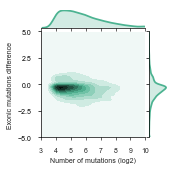

In [11]:
genelevel_exp_df = pd.read_csv(path.join('results', "%s_%s_gene_obs_exp.tsv" % (tumor_type, cluster_id)), sep="\t")

import seaborn as sns
sns.set(style="ticks")
config_plot_params()

x = np.log2(genelevel_exp_df['total_muts']).tolist()
y = genelevel_exp_df['exp_obs_diff'].tolist()

for i in range(0, len(y)):
    if y[i] <= -5:
        y[i] = -5
        
for i in range(0, len(x)):
    if x[i] >= 10:
        x[i] = 10
        
g = sns.jointplot(np.array(x), np.array(y), kind="kde", color="#4CB391", stat_func=None, size=2.25, 
                  ylim=[-5,5], xlim=[3,10], 
                 ).set_axis_labels("Number of mutations (log2)", "Exonic mutations difference")

g.ax_joint.set_xticks(np.arange(3,11,1))
g.ax_joint.set_yticks([-5, -2.5, 0, 2.5, 5])

plt.savefig(path.join('figures', 'figure2C.svg'), bbox_inches='tight')
plt.show()

## Exon/intron & syn/non-syn

Compute the expected and observed number of mutations in exons and introns, and for sysnonymous and non-synonymous mutations for each gene.

The method is described in the **Test for negative selection on exonic mutations** section in the paper.

In [12]:
def compute_pval(obs_muts_1, obs_muts_2, exp_muts1_prob):
    """likelihood ratio test"""
    
    y = obs_muts_1
    N = obs_muts_1 + obs_muts_2
    p1 = y/N  # probability of going exon according to the observed exon/intron muts

    p0 = exp_muts1_prob  # expected probability of going exon
    
    logL1 = y*np.log(p1)+(N-y)*np.log(1-p1) #log likelihood according to p1
    logL0 = y*np.log(p0)+(N-y)*np.log(1-p0) #log likelihood according to p0
        
    my_chi2 = 2*(logL1-logL0)
    
    my_p = chi2.sf(my_chi2, 1) #chi2 score to pvalue
    
    return my_p

In [13]:
exon_intron_results_lol = list()
syn_nonsyn_results_lol = list()

gene_dependent_results = path.join('results', "%s_%s_gene_dependent_results.txt" % (tumor_type, cluster_id))  # Output from other notebook
sample_dependent_results = path.join('results', "%s_%s_sample_dependent_results.txt" % (tumor_type, cluster_id))  # Output from other notebook

genelvl_results_df = pd.read_csv(gene_dependent_results, sep='\t')
samplelvl_results_df = pd.read_csv(sample_dependent_results, sep='\t')

my_genelevel_exp = list()

for my_gene in set(genelvl_results_df['ensembl']):
    sub_genelvl_results = genelvl_results_df[genelvl_results_df['ensembl'] == my_gene]
    sub_samplelvl_results = samplelvl_results_df[samplelvl_results_df['enembl'] == my_gene]

    exons_products_sum = sub_genelvl_results['exons_products_sum'].values[0]
    introns_products_sum = sub_genelvl_results['introns_products_sum'].values[0]

    exons_prob = exons_products_sum/(exons_products_sum+introns_products_sum)
    introns_prob = introns_products_sum/(exons_products_sum+introns_products_sum)

    exon_muts = sum(sub_samplelvl_results['obs_exon_muts'])
    intron_muts = sum(sub_samplelvl_results['obs_intron_muts'])

    total_muts = exon_muts+intron_muts

    exp_exon_muts = total_muts*exons_prob
    exp_intron_muts = total_muts*introns_prob

    syn_products_sum = sub_genelvl_results['syn_products_sum'].values[0]
    nonsyn_products_sum = sub_genelvl_results['nonsyn_products_sum'].values[0]

    syn_prob = syn_products_sum/(syn_products_sum+nonsyn_products_sum)
    nonsyn_prob = nonsyn_products_sum/(syn_products_sum+nonsyn_products_sum)

    syn_muts = sum(sub_samplelvl_results['obs_syn_muts'])
    nonsyn_muts = sum(sub_samplelvl_results['obs_nonsyn_muts'])

    total_cons_muts = syn_muts+nonsyn_muts

    exp_syn_muts = total_cons_muts*syn_prob
    exp_nonsyn_muts = total_cons_muts*nonsyn_prob

    my_genelevel_exp.append([my_gene, exon_muts, exp_exon_muts, intron_muts,
                             exp_intron_muts, syn_muts, nonsyn_muts, exp_syn_muts,
                             exp_nonsyn_muts])

my_genelevel_exp_df = pd.DataFrame(my_genelevel_exp)
my_genelevel_exp_df.columns = ['ensembl', 'exon_muts', 'exp_exon_muts', 'intron_muts',
                               'exp_intron_muts', 'syn_muts', 'nonsyn_muts', 'exp_syn_muts',
                               'exp_nonsyn_muts']

genel_lvl_df = pd.merge(genelvl_results_df, my_genelevel_exp_df, on='ensembl')

genel_lvl_df.to_csv(path.join('results', "%s_%s_obs_exp_syn_nonsym_muts.tsv" % (tumor_type, cluster_id)), 
                    sep="\t", header=True, index=False)

## Mutation burden

Expected and observed number of mutations  (and their decrease) dividing the mutations in 3 categories:
- intronic
- exonic synonymous
- exoninc non-synonymous

In [14]:
genelvl_df = pd.read_csv(path.join('results', "%s_%s_obs_exp_syn_nonsym_muts.tsv" % (tumor_type, cluster_id)), 
                         sep="\t")

genelvl_df['syn_prob'] = genelvl_df['syn_products_sum'] / (genelvl_df['syn_products_sum']
                                                           + genelvl_df['introns_products_sum']
                                                           + genelvl_df['nonsyn_products_sum'])

genelvl_df['nonsyn_prob'] = genelvl_df['nonsyn_products_sum'] / (genelvl_df['syn_products_sum']
                                                           + genelvl_df['introns_products_sum']
                                                           + genelvl_df['nonsyn_products_sum'])

genelvl_df['intr_prob'] = genelvl_df['introns_products_sum'] / (genelvl_df['syn_products_sum']
                                                           + genelvl_df['introns_products_sum']
                                                           + genelvl_df['nonsyn_products_sum'])

genelvl_df['exon_sum_prob'] = ((genelvl_df['syn_products_sum']
                          + genelvl_df['nonsyn_products_sum']) /
                                                            (genelvl_df['syn_products_sum']
                                                           + genelvl_df['introns_products_sum']
                                                           + genelvl_df['nonsyn_products_sum']))


genelvl_df['syn_prob_exon_only'] = genelvl_df['syn_products_sum'] / (genelvl_df['syn_products_sum']
                                                           + genelvl_df['nonsyn_products_sum'])

genelvl_df['nonsyn_prob_exon_only'] = genelvl_df['nonsyn_products_sum'] / (genelvl_df['syn_products_sum']
                                                           + genelvl_df['nonsyn_products_sum'])

obs_syn = sum(genelvl_df['syn_muts'])
obs_nonsyn = sum(genelvl_df['nonsyn_muts'])
obs_intr = sum(genelvl_df['intron_muts'])
obs_exon_sum = obs_syn + obs_nonsyn

exp_syn = sum((genelvl_df['syn_muts'] + genelvl_df['intron_muts'] + genelvl_df['nonsyn_muts'])*genelvl_df['syn_prob'])
exp_nonsyn = sum((genelvl_df['syn_muts'] + genelvl_df['intron_muts'] + genelvl_df['nonsyn_muts'])*genelvl_df['nonsyn_prob'])
exp_intr = sum((genelvl_df['syn_muts'] + genelvl_df['intron_muts'] + genelvl_df['nonsyn_muts'])*genelvl_df['intr_prob'])
exp_exon_sum = sum((genelvl_df['syn_muts'] + genelvl_df['intron_muts'] + genelvl_df['nonsyn_muts'])*genelvl_df['exon_sum_prob'])

# Using only exonic mutations
exp_syn_exon_only = sum((genelvl_df['syn_muts'] + genelvl_df['nonsyn_muts'])*genelvl_df['syn_prob_exon_only'])
exp_nonsyn_exon_only = sum((genelvl_df['syn_muts'] + genelvl_df['nonsyn_muts'])*genelvl_df['nonsyn_prob_exon_only'])

syn_decrease = -(exp_syn-obs_syn)/exp_syn*100
nonsyn_decrease = -(exp_nonsyn-obs_nonsyn)/exp_nonsyn*100
intr_decrease = -(exp_intr-obs_intr)/exp_intr*100
ex_sum_decrease = -(exp_exon_sum-obs_exon_sum)/exp_exon_sum*100

syn_exon_only_decrease = -(exp_syn_exon_only-obs_syn)/exp_syn_exon_only*100
nonsyn_exon_only_decrease = -(exp_nonsyn_exon_only-obs_nonsyn)/exp_nonsyn_exon_only*100

new_df = pd.DataFrame(columns=['type','intron','exon sum','nonsyn','syn', 'nonsyn_exon_only', 'syn_exon_only'])

new_df.loc[0] = ['obs', obs_intr, obs_exon_sum, obs_nonsyn, obs_syn, obs_nonsyn, obs_syn]
new_df.loc[1] = ['expect', exp_intr,exp_exon_sum,exp_nonsyn,exp_syn, exp_nonsyn_exon_only, exp_syn_exon_only]
new_df.loc[2] = ['decrease', intr_decrease,ex_sum_decrease,nonsyn_decrease,syn_decrease, nonsyn_exon_only_decrease, syn_exon_only_decrease]

new_df.to_csv(path.join('results', "%s_%s_obs_exp_muts.tsv" % (tumor_type, cluster_id)), 
              sep="\t", header=True, index=False)

# Panel d) barplots red-black

Number of observed and expected mutations in exons and introns. Number of observed and expected synonymous and non-synonymous mutations.

In [15]:
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

Expected: 541697.0 Observed: 545077.0  Decrease: 0.6%


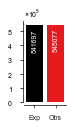

Expected: 8996.0 Observed: 5616.0  Decrease: -37.6%


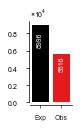

Expected: 7257.0 Observed: 4666.0  Decrease: -35.7%


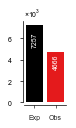

Expected: 1739.0 Observed: 950.0  Decrease: -45.4%


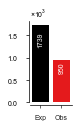

In [16]:
mutations_df = pd.read_csv(path.join('results', "%s_%s_obs_exp_muts.tsv" % (tumor_type, cluster_id)), 
                           sep="\t")

for atype in ['intron', 'exon sum', 'nonsyn', 'syn']:

    fig = plt.figure(figsize=(0.75, 1.5))
    ax = plt.subplot2grid((1, 1), (0, 0))

    exp_muts = round(mutations_df[(mutations_df['type']=='expect')][atype].values[0])
    obs_muts = round(mutations_df[(mutations_df['type']=='obs')][atype].values[0])
    
    decrease = mutations_df[(mutations_df['type']=='decrease')][atype].values[0]
    print('Expected: {} Observed: {}  Decrease: {:.1f}%'.format(exp_muts, obs_muts, decrease))
    
    ax.bar(range(2), [exp_muts, obs_muts], align='center', color=['black', '#e41a1c'])
    plt.xticks(range(2), ['Exp', 'Obs'])

    ax.text(0, round(exp_muts - (exp_muts/5)), '{0:g}'.format(exp_muts),
            color='white', horizontalalignment='center', verticalalignment='center', rotation=90)

    ax.text(1, round(obs_muts - (obs_muts/5)), '{0:g}'.format(obs_muts),
            color='white', horizontalalignment='center', verticalalignment='center', rotation=90)

    ax.margins(0.05)
   
    ax.set_facecolor('none')

    # show the left spline
    for axis in ['right', 'top']:
        ax.spines[axis].set_visible(False)

    for axis in ['bottom', 'left']:
        ax.spines[axis].set_position(('axes', -0.03))

    ax.yaxis.major.locator.set_params(nbins=6)
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.savefig(path.join('figures', 'figure2D_%s.svg' % atype), bbox_inches='tight')
    plt.show()

In [17]:
# P-value of the decrease of exonic mutation burden using introns as reference for computing the expected

exon_obs = round(mutations_df[(mutations_df['type']=='obs')]['exon sum'].values[0])
intron_obs = round(mutations_df[(mutations_df['type']=='obs')]['intron'].values[0])
exon_expected = round(mutations_df[(mutations_df['type']=='expect')]['exon sum'].values[0])
exon_prob = exon_expected / (intron_obs + exon_obs)
compute_pval(exon_obs, intron_obs, exon_prob)

0.0

In [18]:
# P-value of the decrease of exonic mutation burden using introns as reference for computing the expected

def compute_pval_3vars(obs1, exp1, obs2, exp2, obs3, exp3):
    """likelihood ratio test for three variables"""
   
    my_chi2 = 2*(obs1*np.log(obs1/exp1)
                + obs2*np.log(obs2/exp2)
                + obs3*np.log(obs3/exp3))
   
    my_p = chi2.sf(my_chi2, 2) #chi2 score to pvalue. DF is equal to 2
   
    return my_p

syn_obs = round(mutations_df[(mutations_df['type']=='obs')]['syn'].values[0])
syn_exp = round(mutations_df[(mutations_df['type']=='expect')]['syn'].values[0])
nonsyn_obs = round(mutations_df[(mutations_df['type']=='obs')]['nonsyn'].values[0])
nonsyn_exp = round(mutations_df[(mutations_df['type']=='expect')]['nonsyn'].values[0])
intron_obs = round(mutations_df[(mutations_df['type']=='obs')]['intron'].values[0])
intron_exp = round(mutations_df[(mutations_df['type']=='expect')]['intron'].values[0])
compute_pval_3vars(syn_obs, syn_exp, nonsyn_obs, nonsyn_exp, intron_obs, intron_exp)

0.0

### Panel d) barplot brown-purple

Number of observed and expected synonymous and non-synonymous mutations for exonic mutations solely.

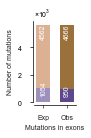

In [19]:
mutations_df = pd.read_csv(path.join('results', "%s_%s_obs_exp_muts.tsv" % (tumor_type, cluster_id)), sep="\t")

syn_muts = mutations_df[(mutations_df['type']=='obs')]['syn'].values[0]
exp_syn_muts = mutations_df[(mutations_df['type']=='expect')]['syn_exon_only'].values[0]
nonsyn_muts = mutations_df[(mutations_df['type']=='obs')]['nonsyn'].values[0]
exp_nonsyn_muts = mutations_df[(mutations_df['type']=='expect')]['nonsyn_exon_only'].values[0]

fig = plt.figure(figsize=(0.75, 1.5))
ax = plt.subplot2grid((1, 1), (0, 0))

N = 2

ind = np.arange(N)    # the x locations for the groups
#width = 0.35       # the width of the bars: can also be len(x) sequence

ax.bar(ind, [exp_syn_muts, syn_muts], color=('#9D90BA', '#5D478D' ), width=0.6)

ax.text(1, round(syn_muts - (syn_muts/10)), '{0:g}'.format(round(syn_muts)),
        color='white', horizontalalignment='center', verticalalignment='center',rotation=90)

ax.text(0, round(exp_syn_muts - (exp_syn_muts/10)), '{0:g}'.format(round(exp_syn_muts)),
        color='white', horizontalalignment='center', verticalalignment='center', rotation=90)

ax.bar(ind, [exp_nonsyn_muts, nonsyn_muts], color=('#dcb193', '#9b713b'), bottom=[exp_syn_muts, syn_muts], width=0.6)

ax.text(1, round((nonsyn_muts + syn_muts) - ((nonsyn_muts + syn_muts)/10)), '{0:g}'.format(round(nonsyn_muts)),
        color='white', horizontalalignment='center', verticalalignment='center', rotation=90)


ax.text(0, round((exp_nonsyn_muts + exp_syn_muts) - ((exp_nonsyn_muts + exp_syn_muts)/10)), '{0:g}'.format(round(exp_nonsyn_muts)),
        color='white', horizontalalignment='center', verticalalignment='center', rotation=90)
    


plt.xticks(range(2), ['Exp', 'Obs'])
ax.margins(0.05)

ax.set_facecolor('none')

# show the left spline
for axis in ['right', 'top']:
    ax.spines[axis].set_visible(False)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_position(('axes', -0.03))

#ax.yaxis.major.locator.set_params(nbins=4)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_formatter(formatter)

ax.set_ylabel('Number of mutations')
ax.set_xlabel('Mutations in exons')


plt.savefig(path.join('figures', 'figure2D_syn_nonsyn.svg'), bbox_inches='tight')
plt.show()

We have not computed a p-value (for the observed and expected number of mutations of synonymous and non synonymous using only exons)

## Mutation rate

Group genes by their mutation rate (mutations divided by the total base pairs) and compute the decrease in exonic mutation burden for each group.

Genes without mutations have been excluded.

In [20]:
sub_results = pd.read_csv(path.join('results', "%s_%s_obs_exp_syn_nonsym_muts.tsv" % (tumor_type, cluster_id)), 
                          sep="\t")

# Exclude genes with mut_rate = 0
sub_results['mutrate'] = ((sub_results['exon_muts'] + sub_results['intron_muts']) /
                            (sub_results['exons_bp'] + sub_results['introns_bp']))
sub_results = sub_results.sort_values(by='mutrate', ascending=True)
sub_results = sub_results[sub_results['mutrate'] != 0]

groups_size = int(len(sub_results.index.tolist()) / n_groups)

mutrate_levels = dict()

# list genof each group
for i in range(n_groups):
    my_start = i * groups_size
    my_end = (i + 1) * groups_size

    if i == max(range(n_groups)):
        my_end = len(sub_results.index.tolist())

    sub_exin_prop_df = sub_results.iloc[my_start:my_end]
    sub_exin_genes = sub_exin_prop_df['ensembl'].tolist()

    mutrate_levels[i] = sub_exin_genes

exons_results_prop = list()

for mutrate_level in mutrate_levels:
    genes_list = mutrate_levels[mutrate_level]

    exons_bp = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exons_bp'])

    obs_exon_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exon_muts'])
    obs_intron_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['intron_muts'])

    total_muts = obs_exon_muts+obs_intron_muts

    obs_exons_rate = obs_exon_muts/exons_bp

    exp_exon_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exp_exon_muts'])
    exp_exons_rate = exp_exon_muts/exons_bp
     
    decrease_over_expected = -(exp_exons_rate-obs_exons_rate)/exp_exons_rate*100
    
    exp_exon_prob = exp_exon_muts/total_muts
    pval = compute_pval(obs_exon_muts, obs_intron_muts, exp_exon_prob)

    exons_results_prop.append([mutrate_level, decrease_over_expected, pval])
  
results_prop_df = pd.DataFrame(exons_results_prop)
results_prop_df.columns = ['bin', 'decrease_over_expected', 'pval']

results_prop_df.to_csv(path.join('results', "%s_%s_mutation_rate.tsv" % (tumor_type, cluster_id)), 
                       sep="\t", header=True, index=False)

### Panel e) mutation rate

Decrease in exonic mutation burden based on genes grouped by mutation rate

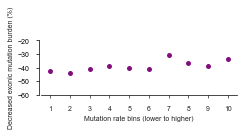

In [21]:
mut_rate_df = pd.read_csv(path.join('results', "%s_%s_mutation_rate.tsv" % (tumor_type, cluster_id)), sep="\t")

fig = plt.figure(figsize=(3.5, 1))
ax1 = plt.subplot2grid((1, 1), (0, 0))


# for the significant ones
tmp1 = mut_rate_df[mut_rate_df['pval'] < 0.05]
x = np.array(tmp1['bin'].tolist()) + 1
y = tmp1['decrease_over_expected'].tolist()
ax1.plot(x, y, '.', label='exon_mutrate', color='#810f7c', markersize=10)

# for the non-significant ones
tmp1 = mut_rate_df[mut_rate_df['pval'] >= 0.05]
x = np.array(tmp1['bin'].tolist()) + 1
y = tmp1['decrease_over_expected'].tolist()
ax1.plot(x, y, '.', label='exon_mutrate', color='#8c96c6', markersize=108)

ax1.set_ylim(-60, -20)

ax1.set_facecolor('none')
ax1.set_ylabel('Decreased exonic mutation burden (%)')
ax1.set_xlabel('Mutation rate bins (lower to higher)')

loc = plticker.MultipleLocator(base=1) 
ax1.xaxis.set_major_locator(loc)

# show the left spline
for axis in ['right', 'top']:
    ax1.spines[axis].set_visible(False)

for axis in ['bottom', 'left']:
    ax1.spines[axis].set_position(('axes', -0.01))
    
ax1.margins(0.05)

    
ax1.yaxis.major.locator.set_params(nbins=4)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')

plt.savefig(path.join('figures', 'figure2E_mutrate.svg'), bbox_inches='tight')
plt.show()

## Expression

Group genes by their expression and compute the decrease in exonic mutation burden for each group.

In [22]:
sub_results = pd.read_csv(path.join('results', "%s_%s_obs_exp_syn_nonsym_muts.tsv" % (tumor_type, cluster_id)), 
                          sep="\t")

sub_results['mutrate'] = ((sub_results['exon_muts'] + sub_results['intron_muts']) /
                            (sub_results['exons_bp'] + sub_results['introns_bp']))
sub_results = sub_results.sort_values(by='mutrate', ascending=True)
sub_results = sub_results[sub_results['mutrate'] != 0]

expression_df = pd.read_csv(expression_file, sep="\t", header=0)
expression_df['ENSEMBL_ID'] = expression_df.apply(lambda x: remove_version_ensembl(x, 'ENSEMBL_ID'), axis=1)
expression_df.index = expression_df['ENSEMBL_ID']

sample_dependent_results = path.join('results', "%s_%s_sample_dependent_results.txt" % (tumor_type, cluster_id))  # Output from other notebook

samplelvl_results_df = pd.read_csv(sample_dependent_results, sep='\t')

ttype_samples = list(set(samplelvl_results_df['sample']))
ttype_expression_df = expression_df[ttype_samples]

my_genes_to_expr = sub_results['ensembl'].tolist()

ttype_expression_df = ttype_expression_df[ttype_expression_df.index.isin(my_genes_to_expr)]

ttype_expression_df['median'] = ttype_expression_df.apply(lambda x: np.percentile(x, 75), axis=1)  # Very strict definition of non expressed
ttype_expression_df = ttype_expression_df.sort_values(by='median', ascending=False)
very_low_expression_df = ttype_expression_df[ttype_expression_df['median'] == 0]
not_very_low_expression_df = ttype_expression_df[ttype_expression_df['median'] != 0]

expr_levels = perform_analysis_per_group(n_groups=n_groups-1,
                               not_very_low_expression_df=not_very_low_expression_df,
                               very_low_expression_df=very_low_expression_df)

exons_results_prop = list()

for my_expr_level in expr_levels.keys():
    genes_list = expr_levels[my_expr_level]

    print(len(genes_list))

    if my_expr_level == 'very_low':
        my_expr_level = 9
    
    exons_bp = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exons_bp'])

    obs_exon_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exon_muts'])
    obs_intron_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['intron_muts'])

    total_muts = obs_exon_muts+obs_intron_muts

    obs_exons_rate = obs_exon_muts/exons_bp

    exp_exon_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exp_exon_muts'])
    exp_exons_rate = exp_exon_muts/exons_bp
    
    decrease_over_expected = -(exp_exons_rate-obs_exons_rate)/exp_exons_rate*100
    
    exp_exon_prob = exp_exon_muts/total_muts
    pval = compute_pval(obs_exon_muts, obs_intron_muts, exp_exon_prob)

    exons_results_prop.append([my_expr_level, decrease_over_expected, pval])
    
results_prop_df = pd.DataFrame(exons_results_prop)
results_prop_df.columns = ['bin', 'decrease_over_expected', 'pval']

results_prop_df.to_csv(path.join('results', "%s_%s_expression.tsv" % (tumor_type, cluster_id)), 
                       sep="\t", header=True, index=False)

1006
1006
1006
1006
1006
1006
1006
1006
1013
539


### Panel e) expression

Decrease in exonic mutation burden based on genes grouped by expression

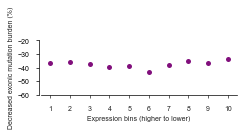

In [23]:
expression_df = pd.read_csv(path.join('results', "%s_%s_expression.tsv" % (tumor_type, cluster_id)), 
                            sep="\t")

fig = plt.figure(figsize=(3.5, 1))
ax1 = plt.subplot2grid((1, 1), (0, 0))

# for the significant ones
tmp1 = expression_df[expression_df['pval'] < 0.05]
x = np.array(tmp1['bin'].tolist()) + 1
y = tmp1['decrease_over_expected'].tolist()
ax1.plot(x, y, '.', label='exon_mutrate', color='#810f7c', markersize=10)

# for the non-significant ones
tmp1 = expression_df[expression_df['pval'] >= 0.05]
x = np.array(tmp1['bin'].tolist()) + 1
y = tmp1['decrease_over_expected'].tolist()
ax1.plot(x, y, '.', label='exon_mutrate', color='#8c96c6', markersize=10)

ax1.set_ylim(-60, -20)

ax1.set_facecolor('none')
ax1.set_ylabel('Decreased exonic mutation burden (%)')
ax1.set_xlabel('Expression bins (higher to lower)')

loc = plticker.MultipleLocator(base=1) 
ax1.xaxis.set_major_locator(loc)

# show the left spline
for axis in ['right', 'top']:
    ax1.spines[axis].set_visible(False)

for axis in ['bottom', 'left']:
    ax1.spines[axis].set_position(('axes', -0.01))
    
ax1.margins(0.05)

    
ax1.yaxis.major.locator.set_params(nbins=4)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')

plt.savefig(path.join('figures', 'figure2E_expr.svg'), bbox_inches='tight')
plt.show()

## Replication time

Group genes by their replication time and compute the decrease in exonic mutation burden for each group.

In [24]:
sub_results = pd.read_csv(path.join('results', "%s_%s_obs_exp_syn_nonsym_muts.tsv" % (tumor_type, cluster_id)), 
                          sep="\t")

sub_results['mutrate'] = ((sub_results['exon_muts'] + sub_results['intron_muts']) /
                            (sub_results['exons_bp'] + sub_results['introns_bp']))
sub_results = sub_results[sub_results['mutrate'] != 0]

sub_results = sub_results.sort_values(by='reptime', ascending=False)

groups_size = int(len(sub_results.index.tolist()) / n_groups)

reptime_levels = dict()

# list genof each group
for i in range(n_groups):
    my_start = i * groups_size
    my_end = (i + 1) * groups_size

    if i == max(range(n_groups)):
        my_end = len(sub_results.index.tolist())

    sub_exin_prop_df = sub_results.iloc[my_start:my_end]
    sub_exin_genes = sub_exin_prop_df['ensembl'].tolist()

    reptime_levels[i] = sub_exin_genes

exons_results_prop = list()

for reptime_level in reptime_levels:
    genes_list = reptime_levels[reptime_level]

    exons_bp = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exons_bp'])

    obs_exon_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exon_muts'])
    obs_intron_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['intron_muts'])

    total_muts = obs_exon_muts+obs_intron_muts

    obs_exons_rate = obs_exon_muts/exons_bp

    exp_exon_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exp_exon_muts'])
    exp_exons_rate = exp_exon_muts/exons_bp
      
    decrease_over_expected = -(exp_exons_rate-obs_exons_rate)/exp_exons_rate*100
    
    exp_exon_prob = exp_exon_muts/total_muts
    pval = compute_pval(obs_exon_muts, obs_intron_muts, exp_exon_prob)

    exons_results_prop.append([reptime_level, decrease_over_expected, pval])
  
results_prop_df = pd.DataFrame(exons_results_prop)
results_prop_df.columns = ['bin', 'decrease_over_expected', 'pval']

results_prop_df.to_csv(path.join('results', "%s_%s_replication_time.tsv" % (tumor_type, cluster_id)), 
                       sep="\t", header=True, index=False)

### Panel e) replication time

Decrease in exonic mutation burden based on genes grouped by replication time

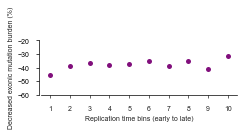

In [25]:
rep_time_df = pd.read_csv(path.join('results', "%s_%s_replication_time.tsv" % (tumor_type, cluster_id)), sep="\t")

fig = plt.figure(figsize=(3.5, 1))
ax1 = plt.subplot2grid((1, 1), (0, 0))

# for the significant ones
tmp1 = rep_time_df[rep_time_df['pval'] < 0.05]
x = np.array(tmp1['bin'].tolist()) + 1
y = tmp1['decrease_over_expected'].tolist()
ax1.plot(x, y, '.', label='exon_mutrate', color='#810f7c', markersize=10)

# for the non-significant ones
tmp1 = rep_time_df[rep_time_df['pval'] >= 0.05]
x = np.array(tmp1['bin'].tolist()) + 1
y = tmp1['decrease_over_expected'].tolist()
ax1.plot(x, y, '.', label='exon_mutrate', color='#8c96c6', markersize=10)

ax1.set_ylim(-60, -20)

ax1.set_facecolor('none')
ax1.set_ylabel('Decreased exonic mutation burden (%)')
ax1.set_xlabel('Replication time bins (early to late)')

loc = plticker.MultipleLocator(base=1) 
ax1.xaxis.set_major_locator(loc)

# show the left spline
for axis in ['right', 'top']:
    ax1.spines[axis].set_visible(False)

for axis in ['bottom', 'left']:
    ax1.spines[axis].set_position(('axes', -0.01))
    
ax1.margins(0.05)

    
ax1.yaxis.major.locator.set_params(nbins=4)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')

plt.savefig(path.join('figures', 'figure2E_rep_time.svg'), bbox_inches='tight')
plt.show()

## H3K36me3

Group genes by the H3K36me3 genic coverage and compute the decrease in exonic mutation burden for each group.

In [26]:
histon_mark = 'E075-H3K36me3'

exons_coords_filtered = path.join(coordinates_folder, '%s_filtered_exons_coords.txt' % tumor_type)  # Output from other notebook
intron_coords_filtered = path.join(coordinates_folder, '%s_filtered_introns_coords.txt' % tumor_type)  # Output from other notebook

sub_results = pd.read_csv(path.join('results', "%s_%s_obs_exp_syn_nonsym_muts.tsv" % (tumor_type, cluster_id)), 
                          sep="\t")

sub_results['mutrate'] = ((sub_results['exon_muts'] + sub_results['intron_muts']) /
                            (sub_results['exons_bp'] + sub_results['introns_bp']))
sub_results = sub_results[sub_results['mutrate'] != 0]

# Read histone data
histone_reads_file = path.join(histone_data_folder, '%s.tagAlign.gz' % histon_mark)
histone_data_df = pd.read_csv(histone_reads_file, sep='\t', header=None)
histone_data_df = histone_data_df[[0,1,2]]
histon_mark_bed = pybedtools.BedTool.from_dataframe(histone_data_df)

exons_coords_df = pd.read_csv(exons_coords_filtered, sep="\t", low_memory=False)
exons_coords_df['ensembl'] = exons_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl']
sub_exons_coords_bed = pybedtools.BedTool.from_dataframe(exons_coords_df)

introns_coords_df = pd.read_csv(intron_coords_filtered, sep="\t", low_memory=False)
introns_coords_df['ensembl'] = introns_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
introns_coords_df.columns  =['chr', 'start', 'end', 'ensembl']
sub_introns_coords_bed = pybedtools.BedTool.from_dataframe(introns_coords_df)

# Interesct histone data with exons and introns coordinates
my_exon_histon_bed = sub_exons_coords_bed.intersect(histon_mark_bed, wao=True)
my_exon_histon_df = pd.read_table(my_exon_histon_bed.fn, names = ['region_chr', 'region_start', 'region_end',
                                    'ensembl', 'read_chr', 'read_start', 'read_end', 'overlap_bp'])
my_exons_reads = my_exon_histon_df.groupby('ensembl')['overlap_bp'].sum()
my_exons_reads = pd.DataFrame({'ensembl':my_exons_reads.index, 'exon_bases_covered':my_exons_reads.values})

my_intron_histon_bed = sub_introns_coords_bed.intersect(histon_mark_bed, wao=True)
my_intron_histon_df = pd.read_table(my_intron_histon_bed.fn, names = ['region_chr', 'region_start', 'region_end',
                                    'ensembl', 'read_chr', 'read_start', 'read_end', 'overlap_bp'])
my_introns_reads = my_intron_histon_df.groupby('ensembl')['overlap_bp'].sum()
my_introns_reads = pd.DataFrame({'ensembl':my_introns_reads.index, 'intron_bases_covered':my_introns_reads.values})

my_merged_histon_reads = pd.merge(my_exons_reads, my_introns_reads, on='ensembl')

sub_results_histon = pd.merge(sub_results, my_merged_histon_reads, on='ensembl')

sub_results_histon['exons_histon_rate'] = (sub_results_histon['exon_bases_covered']/
                                                       sub_results_histon['exons_bp'])
sub_results_histon['introns_histon_rate'] = (sub_results_histon['intron_bases_covered']/
                                                         sub_results_histon['introns_bp'])
sub_results_histon['total_histon_rate'] = ((sub_results_histon['intron_bases_covered'] + sub_results_histon['exon_bases_covered'])/
                                                         (sub_results_histon['introns_bp'] + sub_results_histon['exons_bp']))
sub_results_histon['ex_in_histon_fc'] = sub_results_histon['exons_histon_rate']/sub_results_histon['introns_histon_rate']
filtered_results_histon = sub_results_histon[(sub_results_histon['exon_bases_covered'] != 0) &
                                                   (sub_results_histon['intron_bases_covered'] != 0)]

filtered_results_histon = filtered_results_histon.sort_values(by='total_histon_rate', ascending=True)

sub_results = filtered_results_histon

groups_size = int(len(filtered_results_histon.index.tolist()) / n_groups)

histon_levels = dict()

for i in range(n_groups):
    my_start = i * groups_size
    my_end = (i + 1) * groups_size

    if i == max(range(n_groups)):
        my_end = len(filtered_results_histon.index.tolist())

    sub_exin_prop_df = filtered_results_histon.iloc[my_start:my_end]
    sub_exin_genes = sub_exin_prop_df['ensembl'].tolist()

    histon_levels[i] = sub_exin_genes

exons_results_prop = list()

for histone_level in histon_levels:
    genes_list = histon_levels[histone_level]
    
    print(len(genes_list))

    exons_bp = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exons_bp'])

    obs_exon_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exon_muts'])
    obs_intron_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['intron_muts'])

    total_muts = obs_exon_muts+obs_intron_muts

    obs_exons_rate = obs_exon_muts/exons_bp

    exp_exon_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exp_exon_muts'])
    exp_exons_rate = exp_exon_muts/exons_bp
      
    decrease_over_expected = -(exp_exons_rate-obs_exons_rate)/exp_exons_rate*100
    
    exp_exon_prob = exp_exon_muts/total_muts
    pval = compute_pval(obs_exon_muts, obs_intron_muts, exp_exon_prob)

    exons_results_prop.append([histone_level, decrease_over_expected, pval])
  
results_prop_df = pd.DataFrame(exons_results_prop)
results_prop_df.columns = ['bin', 'decrease_over_expected', 'pval']

results_prop_df.to_csv(path.join('results', "%s_%s_histone_bins.tsv" % (tumor_type, cluster_id)), 
                       sep="\t", header=True, index=False)

901
901
901
901
901
901
901
901
901
904


### Panel e) H3K36me3

Decrease in exonic mutation burden based on genes grouped by H3K36me3 genic coverage

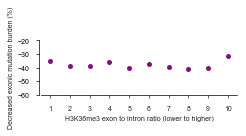

In [27]:
histone_df = pd.read_csv(path.join('results', "%s_%s_histone_bins.tsv" % (tumor_type, cluster_id)), sep="\t")

fig = plt.figure(figsize=(3.5, 1))
ax1 = plt.subplot2grid((1, 1), (0, 0))

# for the significant ones
tmp1 = histone_df[histone_df['pval'] < 0.05]
x = np.array(tmp1['bin'].tolist()) + 1
y = tmp1['decrease_over_expected'].tolist()[::-1] # note here I reverse the data point to go from histone ratio higher to lower
ax1.plot(x, y, '.', label='exon_mutrate', color='#810f7c', markersize=10)

# for the non-significant ones
tmp1 = histone_df[histone_df['pval'] >= 0.05]
x = np.array(tmp1['bin'].tolist()) + 1
y = tmp1['decrease_over_expected'].tolist()[::-1] # note here I reverse the data point to go from histone ratio higher to lower
ax1.plot(x, y, '.', label='exon_mutrate', color='#8c96c6', markersize=10)

ax1.set_ylim(-60, -20)

ax1.set_facecolor('none')
ax1.set_ylabel('Decreased exonic mutation burden (%)')
ax1.set_xlabel('H3K36me3 exon to intron ratio (lower to higher)')

loc = plticker.MultipleLocator(base=1) 
ax1.xaxis.set_major_locator(loc)

# show the left spline
for axis in ['right', 'top']:
    ax1.spines[axis].set_visible(False)

for axis in ['bottom', 'left']:
    ax1.spines[axis].set_position(('axes', -0.01))
    
ax1.margins(0.05)
    
ax1.yaxis.major.locator.set_params(nbins=4)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')

plt.savefig(path.join('figures', 'figure2E_histone.svg'), bbox_inches='tight')
plt.show()

## Stratify exons

Compute expected and observed number of mutations per position. Then group the exons by bins and compute the decrese in the exonic mutation rate.

In [28]:
def compute_exons_per_gene(exons_position_df):
    """Given a df numbered exons per gene, get the total number of exons per gene"""
    
    my_exons_per_gene = list()

    for index, my_df in exons_position_df.groupby(3):
        my_exons_per_gene.append([index, my_df[8].max()])
        
    my_exons_per_gene_df = pd.DataFrame(my_exons_per_gene)
    my_exons_per_gene_df.columns = ['gene', 'n_exons']

    return my_exons_per_gene_df

In [29]:
middle_distance_threshold = 1000
my_bins = [[2],[3],[4],[5],[6],[7],[8],[9],[10],[11,15],[16,20],[21,40],[41,100],['second_last']]
nucleotides = set(['A', 'T', 'C', 'G'])

# Read mutations
mutations_file = path.join(mutations_folder, "%s.bed.gz" % tumor_type)
mutations_df = pd.read_csv(mutations_file, sep="\t", header=None) 
mutations_df.columns = ['CHROMOSOME', 'START', 'POSITION', 'REF', 'ALT', 'SAMPLE', 'TYPE']
mutations_df = mutations_df[mutations_df['TYPE'] == 'subs']

clusters_df = pd.read_csv(clusters_file, sep='\t', low_memory=False)
ttype_clusters_df = clusters_df[clusters_df['ctype'] == tumor_type]
cluster_samples = ttype_clusters_df[ttype_clusters_df['cluster'] == cluster_id]['sample_id'].tolist()

cluster_mutations_df = mutations_df[mutations_df['SAMPLE'].isin(cluster_samples)]
sub_mutations_df = cluster_mutations_df[['CHROMOSOME', 'POSITION', 'SAMPLE']].copy()
sub_mutations_df['START'] = sub_mutations_df['POSITION'] - 1
sub_mutations_df = sub_mutations_df[['CHROMOSOME', 'START', 'POSITION', 'SAMPLE']]
sub_mutations_df.columns = ['chr', 'start', 'end', 'sample']
sub_mutations_bed = pybedtools.BedTool.from_dataframe(sub_mutations_df)

all_signatures = pd.read_csv(path.join('results', "signatures.txt"), sep='\t')  # Output from other notebook
probability_name = 'Probability_' + tumor_type + '_' + cluster_id
sub_signatures_df = all_signatures[['mutation', probability_name]]
signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()

# Read exons coordinates
exons_position_df = pd.read_csv(exons_coords, sep='\t', header=None)
my_exons_per_gene_df = compute_exons_per_gene(exons_position_df)
max_n_exons = my_exons_per_gene_df['n_exons'].max()
my_exons_list = list(range(1,max_n_exons+1))
exons_position_bed = pybedtools.BedTool.from_dataframe(exons_position_df)

# Get last and second last exons
last_bed = pybedtools.BedTool.from_dataframe(exons_position_df[exons_position_df.loc[:, 9] == 'last'])
others_than_last_bed = pybedtools.BedTool.from_dataframe(exons_position_df[exons_position_df.loc[:, 9]!='last'])
last_bed = last_bed.merge(c='6,8', o='distinct')
last_bed = last_bed.intersect(others_than_last_bed, wo=True, sorted=True, v=True)  # drop all segment that overlap and are classified as last and any other category 
second_last_bed = pybedtools.BedTool.from_dataframe(exons_position_df[exons_position_df.loc[:, 9] == 'secondlast'])
others_than_second_last_bed = pybedtools.BedTool.from_dataframe(exons_position_df[exons_position_df.loc[:, 9]!='secondlast'])
second_last_bed = second_last_bed.merge(c='6,8', o='distinct')
second_last_bed = second_last_bed.intersect(others_than_second_last_bed, wo=True, sorted=True, v=True)  # drop all segment that overlap and are classified as last and any other category 
second_and_last_bed = pybedtools.BedTool.from_dataframe(pd.concat([
        pd.read_table(last_bed.fn, names=['chr', 'start', 'end', 'strand', 'ensembl']),
        pd.read_table(second_last_bed.fn, names=['chr', 'start', 'end', 'strand', 'ensembl'])
    ])).sort().merge()

exon_position_results = list()

for my_exon_position in my_exons_list:

    if my_exon_position > 100:
        break

    # TODO comment
    df = exons_position_df[exons_position_df.loc[:, 8] == my_exon_position]
    bed = pybedtools.BedTool.from_dataframe(df)
    bed = bed.merge(c='6,8', o='distinct')
    bed = bed.intersect(exons_position_bed, wo=True, sorted=True)
    bed = bed.merge(c='4,5,14', o='distinct')    
    my_position_df = pd.read_table(bed.fn, names=['chr', 'start', 'end', 'strand', 'ensembl', 'position'])
    my_position_df = my_position_df[my_position_df['position'] == str(my_exon_position)]  
    my_position_bed = pybedtools.BedTool.from_dataframe(my_position_df)
    
    # Remove segmets that overlap with last or second last exons
    inter_my_position_bed = my_position_bed.intersect(second_and_last_bed, wao=True)
    inter_my_position_df = pd.read_table(inter_my_position_bed.fn, names = 
                                         ['chr', 'start', 'end', 'strand', 'ensembl', 'position', 'chr_last', 'start_last', 'end_last', 'overlap']
                                        )
    inter_my_position_df = inter_my_position_df[inter_my_position_df['overlap'] == 0][['chr', 'start', 'end', 'strand', 'ensembl', 'position']]
    
    exons_coords_symbol_df = inter_my_position_df.copy()
    
    # Find the base pairs of interest
    exons_coords_symbol_df['exon_size'] = (exons_coords_symbol_df['end'] - exons_coords_symbol_df['start'])
    exons_coords_symbol_df['exon_middle_start'] = (exons_coords_symbol_df['start'] + exons_coords_symbol_df['exon_size']/2)
    exons_coords_symbol_df['exon_middle_start'] = exons_coords_symbol_df.apply(lambda x:
                                                       math.floor(x['exon_middle_start']), axis=1)
    exons_coords_symbol_df['exon_middle_end'] = exons_coords_symbol_df['exon_middle_start'] + 1
    exons_coords_symbol_df['region_start'] = exons_coords_symbol_df['start'] - middle_distance_threshold
    exons_coords_symbol_df['region_end'] = exons_coords_symbol_df['end'] + middle_distance_threshold

    sub_exons_coords = exons_coords_symbol_df[['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start',
                                          'exon_middle_end']]
    
    min_size = sub_exons_coords['exon_size'].describe()['min']
    low_quart_size =sub_exons_coords['exon_size'].describe()['25%']
    median_size = sub_exons_coords['exon_size'].describe()['50%']
    high_quart_size = sub_exons_coords['exon_size'].describe()['75%']
    max_size = sub_exons_coords['exon_size'].describe()['max']

    sub_exons_coords_bed = pybedtools.BedTool.from_dataframe(sub_exons_coords)
    my_bed = sub_exons_coords_bed.intersect(sub_mutations_bed, wao=True)
    mutations_in_range = pd.read_table(my_bed.fn, names = ['range_chr', 'range_start', 'range_end',
                            'ensembl','region_size', 'region_middle_start', 'region_middle_end',
                            'mut_chr', 'mut_start', 'mut_end', 'sample', 'overlap_bp'],  sep="\s+", index_col=False)
    mutations_in_range = mutations_in_range[mutations_in_range['overlap_bp'] != 0]
    mutations_in_range['relative_start'] = mutations_in_range['mut_start'] - mutations_in_range['region_middle_start']

    final_position_prob_df = pd.DataFrame()
    filtered_n_exon_coords = len(sub_exons_coords)

    # Get the relative position and the probability associated
    my_position_results = list()
    for my_row in sub_exons_coords.values.tolist():

        position_prob_lol = list()
        my_chr = my_row[0][3:]
        my_start = int(my_row[1])
        my_end = int(my_row[2])
        n_bases = my_end - my_start
        my_ensembl = my_row[3]
        exon_size = my_row[4]

        my_region_muts = mutations_in_range[(mutations_in_range['range_start'] >= my_start) &
                               (mutations_in_range['range_end'] <= my_end) &
                               (mutations_in_range['range_chr'] == 'chr'+my_chr)]

        my_n_region_muts = len(my_region_muts)
        if my_n_region_muts == 0:
            continue

        # Get the ref and alternate triplets
        my_exon_bases = hg19(my_chr, my_start, n_bases+2)
        my_trinucleotides = [my_exon_bases[i:i+3] for i in range(len(my_exon_bases)-2)]
        i = 0
        for my_trinucleotide in my_trinucleotides:
            my_ref_base = my_trinucleotide[1].upper()
            my_alt_bases = nucleotides - set(my_ref_base)
            my_base_probs = 0

            previous_base = my_trinucleotide[0]
            next_base = my_trinucleotide[2]

            for alt_base in my_alt_bases:
                tri_ref = previous_base + str(my_ref_base) + next_base
                tri_alt = previous_base + str(alt_base) + next_base
                my_key = str((tri_ref, tri_alt))
                try:
                    my_prob = signatures_dict[my_key][probability_name]
                    my_base_probs = my_base_probs + my_prob
                except:
                    None

            normalized_i = i - (middle_distance_threshold + math.floor(exon_size/2))
            my_row = [normalized_i, my_base_probs]
            position_prob_lol.append(my_row)

            i += 1

        # Compute expected and obserbed number of muts
        position_prob_df = pd.DataFrame(position_prob_lol)
        position_prob_df.columns = ['position', 'probability']
        
        my_total = sum(position_prob_df['probability'])
        position_prob_df['probability'] = position_prob_df['probability']/my_total
        position_prob_df['expected_muts'] = position_prob_df['probability']*my_n_region_muts
        position_prob_df = position_prob_df[['position', 'expected_muts']]

        nucl_exp_results = position_prob_df[(position_prob_df['position'] >= -math.floor(exon_size/2)) & 
                                                (position_prob_df['position'] <= math.floor(exon_size/2))]
        nucl_obs_results = my_region_muts[(my_region_muts['relative_start'] >= -math.floor(exon_size/2)) & 
                                              (my_region_muts['relative_start'] <= math.floor(exon_size/2))]

        nucl_obs_muts = len(nucl_obs_results)
        nucl_exp_muts = nucl_exp_results['expected_muts'].sum()
        my_position_row = [my_ensembl, nucl_obs_muts, nucl_exp_muts]
        my_position_results.append(my_position_row)


    my_position_results_df = pd.DataFrame(my_position_results)

    total_obs_muts = my_position_results_df[1].sum()
    total_exp_muts = my_position_results_df[2].sum()

    pos_decrease = -(total_exp_muts-total_obs_muts)/total_exp_muts*100

    global_position_row = [my_exon_position, total_obs_muts, total_exp_muts, pos_decrease,
                           filtered_n_exon_coords, min_size, low_quart_size, median_size,
                           high_quart_size, max_size]
    
    exon_position_results.append(global_position_row)
    


# Repeat for last and second last exons

second_last_exon_coords_df = pd.read_table(second_last_bed.fn, names=['chr', 'start', 'end', 'strand', 'ensembl'])
last_exon_coords_df = pd.read_table(last_bed.fn, names=['chr', 'start', 'end', 'strand', 'ensembl'])
j = 0
for my_last_df in [second_last_exon_coords_df, last_exon_coords_df]:

    if j == 0:
        my_exon_position = 'second_last'     
    else:
        my_exon_position = 'last'
        
    j += 1
    exons_coords_symbol_df = my_last_df
    exons_coords_symbol_df['exon_size'] = (exons_coords_symbol_df['end']
                                       - exons_coords_symbol_df['start'])
    exons_coords_symbol_df['exon_middle_start'] = (exons_coords_symbol_df['start']
                                                 + exons_coords_symbol_df['exon_size']/2)
    exons_coords_symbol_df['exon_middle_start'] = exons_coords_symbol_df.apply(lambda x:
                                                       math.floor(x['exon_middle_start']),
                                                       axis=1)
    exons_coords_symbol_df['exon_middle_end'] = exons_coords_symbol_df['exon_middle_start'] + 1
    exons_coords_symbol_df['region_start'] = exons_coords_symbol_df['exon_middle_start'] - middle_distance_threshold
    exons_coords_symbol_df['region_end'] = exons_coords_symbol_df['exon_middle_end'] + middle_distance_threshold

    sub_exons_coords = exons_coords_symbol_df[['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start',
                                          'exon_middle_end']]

    min_size = sub_exons_coords['exon_size'].describe()['min']
    low_quart_size =sub_exons_coords['exon_size'].describe()['25%']
    median_size = sub_exons_coords['exon_size'].describe()['50%']
    high_quart_size = sub_exons_coords['exon_size'].describe()['75%']
    max_size = sub_exons_coords['exon_size'].describe()['max']
    
    sub_exons_coords_bed = pybedtools.BedTool.from_dataframe(sub_exons_coords)

    my_bed = sub_exons_coords_bed.intersect(sub_mutations_bed, wao=True)
    mutations_in_range = pd.read_table(my_bed.fn, names = ['range_chr', 'range_start', 'range_end',
                            'ensembl','region_size', 'region_middle_start', 'region_middle_end',
                            'mut_chr', 'mut_start', 'mut_end', 'sample', 'overlap_bp'],  sep="\s+", index_col=False)

    mutations_in_range = mutations_in_range[mutations_in_range['overlap_bp'] != 0]
    mutations_in_range['relative_start'] = mutations_in_range['mut_start'] - mutations_in_range['region_middle_start']

    final_position_prob_df = pd.DataFrame()
    filtered_n_exon_coords = len(sub_exons_coords)
    my_position_results = list()

    for my_row in sub_exons_coords.values.tolist():
        position_prob_lol = list()
        my_chr = my_row[0][3:]
        my_start = int(my_row[1])
        my_end = int(my_row[2])
        n_bases = my_end - my_start
        my_ensembl = my_row[3]
        exon_size = my_row[4]

        my_region_muts = mutations_in_range[(mutations_in_range['range_start'] >= my_start) &
                               (mutations_in_range['range_end'] <= my_end) &
                               (mutations_in_range['range_chr'] == 'chr'+my_chr)]
        my_n_region_muts = len(my_region_muts)
        if my_n_region_muts == 0:
            continue
        my_exon_bases = hg19(my_chr, my_start, n_bases+2)
        my_trinucleotides = [my_exon_bases[i:i+3] for i in range(len(my_exon_bases)-2)]
        i = 0
        for my_trinucleotide in my_trinucleotides:
            my_ref_base = my_trinucleotide[1].upper()
            my_alt_bases = nucleotides - set(my_ref_base)
            my_base_probs = 0
            previous_base = my_trinucleotide[0]
            next_base = my_trinucleotide[2]

            for alt_base in my_alt_bases:
                tri_ref = previous_base + str(my_ref_base) + next_base
                tri_alt = previous_base + str(alt_base) + next_base
                my_key = str((tri_ref, tri_alt))
                try:
                    my_prob = signatures_dict[my_key][probability_name]
                    my_base_probs = my_base_probs + my_prob
                except:
                    None

            normalized_i = i - (middle_distance_threshold + math.floor(exon_size/2))
            my_row = [normalized_i, my_base_probs]
            position_prob_lol.append(my_row)
            i += 1

        position_prob_df = pd.DataFrame(position_prob_lol)
        position_prob_df.columns = ['position', 'probability']

        my_total = sum(position_prob_df['probability'])
        position_prob_df['probability'] = position_prob_df['probability']/my_total
        position_prob_df['expected_muts'] = position_prob_df['probability']*my_n_region_muts

        position_prob_df = position_prob_df[['position', 'expected_muts']]
        nucl_exp_results = position_prob_df[(position_prob_df['position'] >= -math.floor(exon_size/2)) & 
                                                (position_prob_df['position'] <= math.floor(exon_size/2))]

        nucl_obs_results = my_region_muts[(my_region_muts['relative_start'] >= -math.floor(exon_size/2)) & 
                                              (my_region_muts['relative_start'] <= math.floor(exon_size/2))]

        nucl_obs_muts = len(nucl_obs_results)
        nucl_exp_muts = nucl_exp_results['expected_muts'].sum()
        my_position_row = [my_ensembl, nucl_obs_muts, nucl_exp_muts]
        my_position_results.append(my_position_row)

    my_position_results_df = pd.DataFrame(my_position_results)

    total_obs_muts = my_position_results_df[1].sum()
    total_exp_muts = my_position_results_df[2].sum()
    pos_decrease = -(total_exp_muts-total_obs_muts)/total_exp_muts*100

    global_position_row = [my_exon_position, total_obs_muts, total_exp_muts, pos_decrease,
                           filtered_n_exon_coords, min_size, low_quart_size, median_size,
                           high_quart_size, max_size]
    
    exon_position_results.append(global_position_row)

exon_position_results_df = pd.DataFrame(exon_position_results)
exon_position_results_df.columns = ['position', 'obs_muts', 'exp_muts', 'decrease', 'n_exons',
                                    'min_size', 'low_quart_size', 'median_size',
                                    'high_quart_size', 'max_size']

exon_position_results_df['position'] = exon_position_results_df['position'].astype(str)

# Compute the decrease for the bins

my_bins_results = list()

for my_bin in my_bins:
    print(my_bin)
    
    if len(my_bin) == 1:
        my_pos = str(my_bin[0])
        
        sub_df = exon_position_results_df[exon_position_results_df['position'] == my_pos]
        obs_exon_muts = sub_df['obs_muts'].sum()
        exp_exon_muts = sub_df['exp_muts'].sum()
            
    elif len(my_bin) > 1:
        my_max = max(my_bin)
        my_min = min(my_bin)
        
        obs_exon_muts = 0
        exp_exon_muts = 0
        
        my_pos = str(my_min) + '-' + str(my_max)

        
        for current_pos in list(range(my_min, my_max+1)):
                                
            sub_df = exon_position_results_df[exon_position_results_df['position']
                                              == str(current_pos)]
            
            obs_exon_muts = obs_exon_muts + sub_df['obs_muts'].sum()
            exp_exon_muts = exp_exon_muts + sub_df['exp_muts'].sum()

    my_bins_results.append([my_pos, obs_exon_muts, exp_exon_muts])

my_binned_results_df = pd.DataFrame(my_bins_results)
my_binned_results_df['decrease'] = -(my_binned_results_df[2]-my_binned_results_df[1])/my_binned_results_df[2]*100

my_binned_results_df.columns = ['index', 'obs_muts', 'exp_muts', 'decrease']

my_binned_results_df.to_csv(path.join('results', "%s_%s_stratifid_decrease.tsv" % (tumor_type, cluster_id)), 
                            sep="\t", header=True, index=False)

[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11, 15]
[16, 20]
[21, 40]
[41, 100]
['second_last']


### Panel e) exon position

Decrease in exonic mutation burden based on the position of the exons

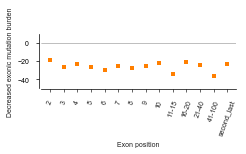

In [30]:
exon_pos_df = pd.read_csv(path.join('results', "%s_%s_stratifid_decrease.tsv" % (tumor_type, cluster_id)), sep="\t")

fig = plt.figure(figsize=(3.5, 1))
ax1 = plt.subplot2grid((1, 1), (0, 0))


x = list(range(0,len(exon_pos_df)))
y = exon_pos_df['decrease'].tolist()
ax1.plot(x, y, 's', label='_mutrate', color='#ff7f00', markersize=4)


ax1.set_ylim(-50, 10)

ax1.set_facecolor('none')
ax1.set_ylabel('Decreased exonic mutation burden')
ax1.set_xlabel('Exon position')

loc = plticker.MultipleLocator(base=1) 
ax1.xaxis.set_major_locator(loc)

ax1.set_xticks(range(len(exon_pos_df['index'])))


#ax1.set_xlim(1,10)

# show the left spline
for axis in ['right', 'top']:
    ax1.spines[axis].set_visible(False)

for axis in ['bottom', 'left']:
    ax1.spines[axis].set_position(('axes', -0.01))
    
ax1.margins(0.05)
ax1.axhline(0, color='gray', lw=0.5)
    
ax1.yaxis.major.locator.set_params(nbins=4)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')

ax1.set_xticklabels(exon_pos_df['index'],rotation=70)

plt.savefig(path.join('figures', 'figure2E_exonpos.svg'), bbox_inches='tight')
plt.show()